In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !git clone https://github.com/zangyuchen2008/StopWords '/content/drive/My Drive/app/Stopwords'

In [9]:
!ls '/content/drive/My Drive/app/'

GPUtest.ipynb	      mnist_cnn.py	    Stopwords
keras-mnist-tutorial  senti_classification  Titanic.csv


In [0]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np 
import pandas as pd
import os
import pickle
import jieba
import re 

In [0]:
# path
father_path= r'/content/drive/My Drive/app/senti_classification'
fasttext_w2v_path = os.path.join(father_path, 'w2v_model','cc.zh.300.vec')
trainset_path = os.path.join(father_path, 'data','train','sentiment_analysis_trainingset.csv')
validationset_path = os.path.join(father_path, 'data','validation','sentiment_analysis_validationset.csv')
testset_path = os.path.join(father_path, 'data','test','sentiment_analysis_testa.csv')
stop_word_path = os.path.join(father_path,'data','stop_words.plk')

In [0]:
train = pd.read_csv(trainset_path,sep=',',encoding='utf8')
validation = pd.read_csv(validationset_path,sep=',',encoding='utf8')
test = pd.read_csv(testset_path,sep=',',encoding='utf8')

## Lable encode

In [0]:
bi_encode = LabelBinarizer()
encodes =[]
target_train = train[['dish_taste']]
for index,v in enumerate(target_train.values.T):
    encodes.append(bi_encode.fit_transform(v))
encodes = np.array(encodes)
y_tra = np.concatenate(encodes,axis=1)

target_val = validation[['dish_taste']]
encodes =[]
for index,v in enumerate(target_val.values.T):
    encodes.append(bi_encode.fit_transform(v))
encodes = np.array(encodes)
y_val = np.concatenate(encodes,axis=1)

## tokenlization

In [14]:
list(train)

['id',
 'content',
 'location_traffic_convenience',
 'location_distance_from_business_district',
 'location_easy_to_find',
 'service_wait_time',
 'service_waiters_attitude',
 'service_parking_convenience',
 'service_serving_speed',
 'price_level',
 'price_cost_effective',
 'price_discount',
 'environment_decoration',
 'environment_noise',
 'environment_space',
 'environment_cleaness',
 'dish_portion',
 'dish_taste',
 'dish_look',
 'dish_recommendation',
 'others_overall_experience',
 'others_willing_to_consume_again']

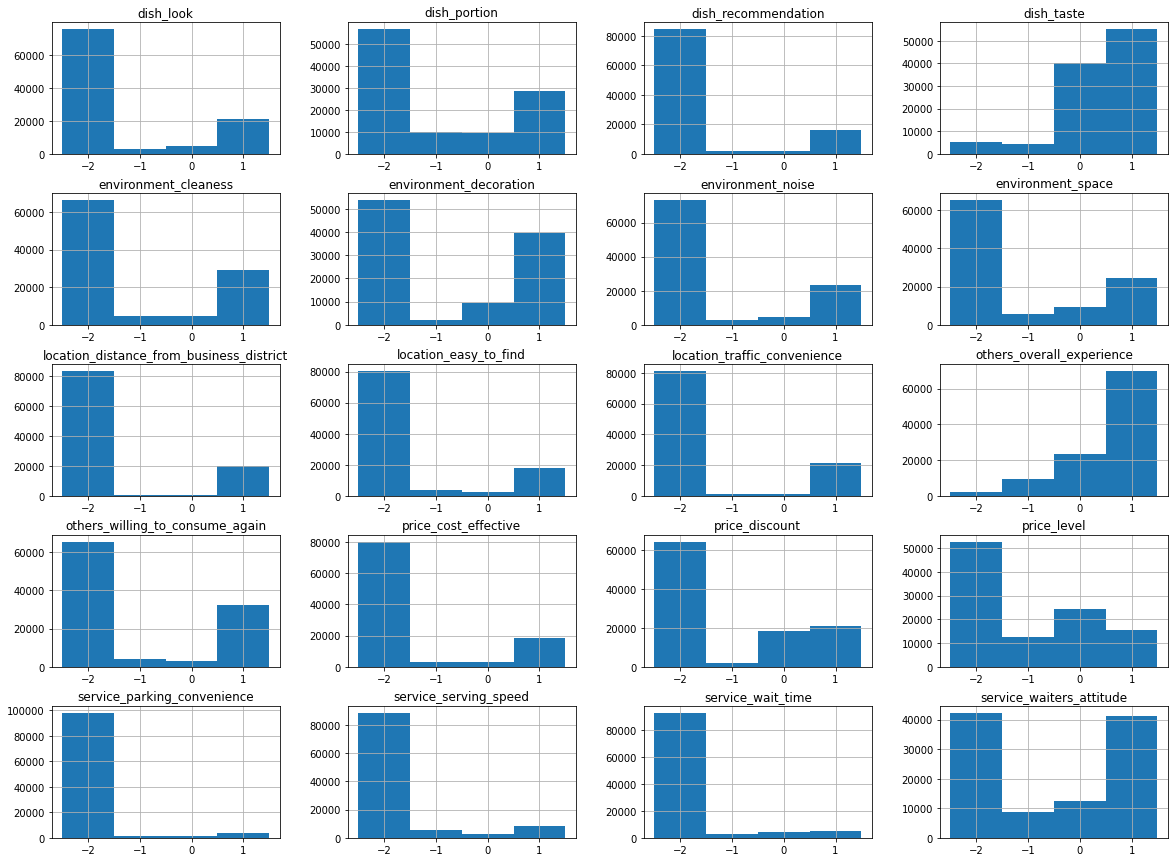

In [15]:
import matplotlib.pyplot as plt
train.iloc[:,2:].hist(bins=[-2.5,-1.5,-0.5,0.5,1.5], figsize=(20,15))
plt.show()

In [0]:
def cut(sen):
    a2=jieba.cut(sen)
    pattern = re.compile('\w+')
    a2=list(filter(pattern.match,a2))
    return a2

In [0]:
# x_tra = train['content'].apply(cut)
# x_val = validation['content'].apply(cut)
# x_te = test['content'].apply(cut)

In [0]:
# pickle.dump([x_tra,x_val,x_te],open(os.path.join(father_path,'cut_tokens.pkl'),'wb'))

In [0]:
# x_tra,x_val,x_te = pickle.load(open(os.path.join(father_path,'cut_tokens.pkl'),'rb'))

In [0]:
# stopwords=pd.read_csv('/content/drive/My Drive/app/Stopwords/stopwords/中文停用词库.txt',encoding='gb2312')
# stopwords= stopwords.values.reshape(745,)

In [0]:
# x_tra = x_tra.apply(lambda x: [w for w in x if w not in stopwords]) 
# x_val = x_val.apply(lambda x: [w for w in x if w not in stopwords]) 
# x_te = x_te.apply(lambda x: [w for w in x if w not in stopwords])

In [0]:
# pickle.dump([x_tra,x_val,x_te],open(os.path.join(father_path,'cut_tokens_wo_stopwords.pkl'),'wb'))

In [0]:
x_tra,x_val,x_te = pickle.load(open(os.path.join(father_path,'cut_tokens_wo_stopwords.pkl'),'rb'))

## sentense embedding

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate,Dropout
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'
np.random.seed(42)

Using TensorFlow backend.


#### create word index vocabulary

In [0]:
max_features = 30000
maxlen = 400
embed_size = 300
tokenizer = text.Tokenizer(num_words=max_features)#create a tokenizer class with max token limit
tokenizer.fit_on_texts(list(x_tra)+list(x_val)+list(x_te)) # texts: can be a list of list of strings.

#### tranform sentense into index integers

In [0]:
X_train = tokenizer.texts_to_sequences(x_tra)# create index(comming from vocabulary) based integer list to represent sequence
X_valid = tokenizer.texts_to_sequences(x_val)
X_test = tokenizer.texts_to_sequences(x_te)

#### padding to make fixed input length

In [0]:
x_train = sequence.pad_sequences(X_train, maxlen=maxlen) # padding zeros to make 100 length encoded seq list, the default padding is pre padding
x_valid = sequence.pad_sequences(X_valid, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

#### create embedding

In [0]:
# from gensim.models import KeyedVectors

In [0]:
# w2v = pickle.load(open(os.path.join(father_path,'fasttext.plk'),'rb'))

In [0]:
# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))
# embedding_matrix = np.zeros((nb_words, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: continue
# #     embedding_vector = w2v[word]
#     if word in w2v: embedding_matrix[i] = w2v[word]

In [0]:
# pickle.dump(embedding_matrix,open('embedding_matrix.plk','wb'))

In [0]:
embedding_matrix= pickle.load(open(os.path.join(father_path,'embedding_matrix.plk'),'rb'))

## create model

GRU model

In [0]:
from sklearn.metrics import precision_score

In [0]:
class GRUEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = y_pred>0.5
            pre_score = precision_score(self.y_val, y_pred,average='macro') #,average='weighted'
            print("\n ROC-AUC - epoch: %d - pre_score: %.6f \n" % (epoch+1, pre_score))

In [0]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(128, return_sequences=True))(x) #bidirectional has two inputs if not specified, see keras doc ,units: Positive integer, dimensionality of the output space.
    x = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional has two inputs if not specified, see keras doc ,units: Positive integer, dimensionality of the output space.
    x = Dropout(0.2)(x)
    avg_pool = GlobalAveragePooling1D()(x) # average over features along time steps direction, l
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool]) # concatenate along axis of avg or max_pool in the list by default, input must be list of tensors
    outp = Dense(4, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy',
    #               optimizer='adam',
    #               metrics=['accuracy'])
    return model

cnn plus attention model

In [0]:
import tensorflow as tf 
import os

In [37]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
check_points = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)

In [0]:
class ATTEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(tf.keras.callbacks.Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = y_pred > 0.5
            pre_score = precision_score(self.y_val, y_pred,average='macro') #,average='weighted'
            print("\n ROC-AUC - epoch: %d - pre_score: %.6f \n" % (epoch+1, pre_score))

In [0]:
def get_cnn_attention_model():
  # Variable-length int sequences.
  query_input = tf.keras.Input(shape=(maxlen,), dtype='int32')
  # value_input = tf.keras.Input(shape=(None,), dtype='int32')

  # Embedding lookup.
  token_embedding = tf.keras.layers.Embedding(max_features, embed_size)
  # Query embeddings of shape [batch_size, Tq, dimension].
  query_embeddings = token_embedding(query_input)
  # Value embeddings of shape [batch_size, Tv, dimension].
  value_embeddings = token_embedding(query_input)

  # CNN layer.
  cnn_layer = tf.keras.layers.Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))
  # Query encoding of shape [batch_size, Tq, filters].
  query_seq_encoding = cnn_layer(query_embeddings)
  # Value encoding of shape [batch_size, Tv, filters].
  value_seq_encoding = cnn_layer(value_embeddings)

  # Query-value attention of shape [batch_size, Tq, filters].
  query_value_attention_seq = tf.keras.layers.Attention()(
      [query_seq_encoding, value_seq_encoding])

  # Reduce over the sequence axis to produce encodings of shape
  # [batch_size, filters].
  query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
      query_seq_encoding)
  query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
      query_value_attention_seq)

  # Concatenate query and document encodings to produce a DNN input layer.
  input_layer = tf.keras.layers.Concatenate()(
      [query_encoding, query_value_attention])
  output_layer = tf.keras.layers.Dense(4,activation="sigmoid")(input_layer)
  model = tf.keras.Model(inputs=query_input,outputs=output_layer)
  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

## Train

In [42]:
at_model= get_cnn_attention_model()
at_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 300)     9000000     input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 100)     120100      embedding[0][0]                  
                                                                 embedding[1][0]                  
______________________________________________________________________________________________

In [43]:
batch_size = 128
epochs = 3
test_index =1000
callback = ATTEvaluation(validation_data=(x_valid, y_val), interval=1)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
hist = at_model.fit(x_train[:test_index,:], y_tra[:test_index,:], batch_size=batch_size, epochs=epochs, validation_data=(x_valid[:test_index,:], y_val[:test_index,:]),callbacks=[callback,earlyStopping,check_points], verbose=2)

Epoch 1/3

 ROC-AUC - epoch: 1 - pre_score: 0.227733 


Epoch 00001: saving model to training_2/cp-0001.ckpt
8/8 - 9s - loss: 2.5884 - accuracy: 0.4630 - val_loss: 2.2209 - val_accuracy: 0.5100
Epoch 2/3

 ROC-AUC - epoch: 2 - pre_score: 0.227733 


Epoch 00002: saving model to training_2/cp-0002.ckpt
8/8 - 8s - loss: 2.0041 - accuracy: 0.5200 - val_loss: 1.7615 - val_accuracy: 0.5100
Epoch 3/3

 ROC-AUC - epoch: 3 - pre_score: 0.227733 


Epoch 00003: saving model to training_2/cp-0003.ckpt
8/8 - 8s - loss: 1.6361 - accuracy: 0.5200 - val_loss: 1.4808 - val_accuracy: 0.5100


In [0]:
model=get_model()
model.summary()

In [83]:
batch_size = 64
epochs = 1
callback = GRUEvaluation(validation_data=(x_valid, y_val), interval=1)

hist = model.fit(x_train[:1000,:], y_tra[:1000,:], batch_size=batch_size, epochs=epochs, validation_data=(x_valid[:1000,:], y_val[:1000,:]),callbacks=[callback], verbose=2)

Train on 1000 samples, validate on 1000 samples
Epoch 1/1
 - 51s - loss: 1.0915 - accuracy: 0.4690 - val_loss: 0.9987 - val_accuracy: 0.5100

 ROC-AUC - epoch: 1 - pre_score: 0.227733 



In [55]:
for index in range(33,1000):
  if np.argmax(y_val[index])==1 and (np.argmax(y_val[index]) != np.argmax(at_model.predict(x_valid[index].reshape(1,400)))):
    print(validation['content'][index])
    print('gold:',np.argmax(y_val[index]))
    print('pretict:',np.argmax(at_model.predict(x_valid[index].reshape(1,400))))
    print('**********************************************')

"       东塱农庄，顾名思义就系位于东塱，以前可算系穷乡僻壤，依家已经系交通方便，前有东沙医院，后有东新高速入口噶要地，车水马龙之地。途径噶巴士非常多，门口就有巴士站名曰东塱站，所以闻名而来一尝农家风味噶人非常多，周末饭市基本要等位，除非你系提早订位噶，或者早于11点前就坐，否则你就只有等等等。
       总体环境非常乡土，也难怪，本来就系东塱村噶老人活动中心改建噶，基本上无装修，就系老人活动中心噶原貌，然后屋顶仲KEEP住大吊扇，门窗依然系80 90年代噶农村风格，大厅大概可以容纳40围，全满噶时候非常吵闹，如果追求安静噶就餐环境千其唔好黎。餐厅后面有一个小公园，入边有好多健身设施，带小朋友过黎可以随时出去玩，仲有村民系附近噶臭河涌垂钓，唔知D鱼系咪会卖翻比东塱农庄，呢点有小小存疑~！
       出品其实并唔系太出色，我觉得不过不失而已，农家菜做到远远无番禺噶餐馆好，而烧鸡烧排骨也都远不及太和，只不过东塱农庄胜在靠近市区，可以话仲系市区范围内，所以呢个也都系距噶制胜之道。
        蒜蓉粉丝蒸元贝：5蚊只，的确抵食，虽然细只，但系好新鲜，推荐~！
        蒸水蟹：15蚊只，蟹偏小，不过都系胜在新鲜，推荐~！
        炸大肠：我对内脏一般，男票话炸得非常好，脆仆仆，搭配泰式甜辣酱，好惹味，推荐~！
        虾仁炒蛋：虾仁唔新鲜，呢点好致命，滑蛋炒得唔算老，不过虾仁已经扣晒分，唔推荐~！
        老娘叉烧：超级超级超级差，三分一碟系叉烧，三分二系梅菜，呃秤，严重唔推荐~！
        沙姜猪利：沙姜好多，洋葱好多，猪利又系10旧都唔够，呃秤，严重唔推荐~！
        总体评价：价钱唔算贵，人均都系30 40 左右，但系菜式必须慎点，招牌噶可以点，其他都系三思啦。"
gold: 1
pretict: 2
**********************************************
"这家餐厅主要经营海鲜，主要的食物是贝壳，儿子吃的很开心，肉质很鲜嫩，进入餐厅服务员很热情的打招呼，一下就把我们吸引住了，团的是双人餐，服务员铺上了一次性餐纸，还每人一个一次性围兜，好可爱吧，海鲜超市是一桶的贝壳虾还有一个小点的鲍鱼，没有餐具有一次性手套戴着用手拿着吃，虾子很新鲜，贝壳处理的也能干净，还有两种调料可以

In [56]:
at_model.save('att_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: att_model/assets


In [72]:
os.path.dirname('/drive/')

'/drive'